# Доклад по библиотеке Prophet

**Студент:** Евтушенко Олег Владимирович

**Группа:** БПМИ2210

**Prophet -** это библиотека, специально разработанная для упрощения процесса прогнозирования различных бизнес-показателей. Ее особенность заключается в том, что она предоставляет эффективные и точные "дефолтные" прогнозы, что делает ее привлекательным выбором для аналитиков, не обладающих глубокими знаниями в области построения предсказательных моделей.

Эта библиотека обеспечивает пользователей возможностью настройки прогнозов, используя понятные человеку параметры. Таким образом, аналитики могут улучшать прогнозы, адаптируя модель к конкретным требованиям без необходимости обширных знаний в области машинного обучения.

По сути, Prophet представляет из себя additive regression model, которая состоит из следующих компонент:

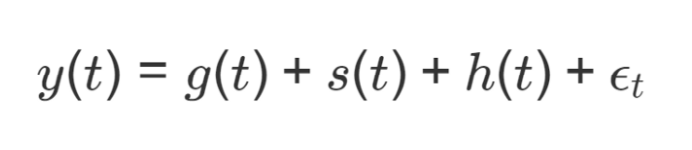



Где:

1) $s(t)$ - Сезонные компоненты (периодические изменения, связанные с недельной и годовой сезонностью)

2) $g(t)$ - это кусочно-линейная или логистическая функция. С линейной функцией все понятно. Логистическая же функция вида $\frac{C}{1+exp(-k(t-b))}$ позволяет моделировать рост с насыщением, когда при увеличении показателя снижается темп его роста. Типичный пример — это рост аудитории приложения или сайта.

3) $h(t)$ - аномальные дни, в том числе и нерегулярные, такие как, например, Black Fridays.

4) Ошибка $\epsilon_{t}$ содержит информацию, которая не учтена моделью.

**Важно** - Вводные данные для библиотеки Prophet всегда представляют собой фрейм данных с двумя столбцами: ds и y. Столбец ds (метка даты) должен иметь формат, ожидаемый библиотекой Pandas, предпочтительно YYYY-MM-DD для даты или YYYY-MM-DD HH:MM:SS для временной метки. Столбец y должен быть числовым и представлять измерение, которое мы хотим прогнозировать.

Хватит теории, перейдем к практике. В качестве примера рассмотрим временной ряд логарифмированных ежедневных просмотров страницы Википедии о Пейтоне Мэннинге. Страница Пейтона Мэннинга является отличным примером, поскольку с ее помощью можно проиллюстрировать некоторые особенности Prophet, такие как множественная сезонность, изменяющиеся темпы роста и возможность моделирования особых дней (таких как выступления Мэннинга в плей-офф и на Супербоуле к примеру).

Для начала импортируем библиотеки, которые могут пригодиться

In [89]:
import numpy as np
import pandas as pd
import sklearn.model_selection
import sklearn.linear_model
import sklearn.metrics
import plotly.express as px
from time import sleep
from prophet import Prophet

Импортируем наши данные и посмотрим как они выглядят

In [90]:
df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv')
df.sample(15)

,ds,y
2698,2015-06-27,7.454720
2633,2015-04-23,7.485492
1218,2011-05-30,7.403670
32,2008-01-11,8.292799
264,2008-09-26,7.526718
2347,2014-07-09,7.226936
413,2009-02-24,7.571474
1480,2012-02-20,9.115920
1776,2012-12-13,8.703009
1560,2012-05-11,7.869402


Как видим, данные соответствуют замечанию в разделе **Важно**, поэтому можем приступить к работе

Создадим новый объект класса Prophet. Любые параметры для процедуры прогнозирования передаются в конструктор. Затем вызывается его метод fit, в который передается исторический фрейм данных. Для начала вызовем конструктор по умолчанию.

In [91]:
model = Prophet()
model.fit(df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmptg2_vgdu/56zmscbv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptg2_vgdu/iiiie40l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4834', 'data', 'file=/tmp/tmptg2_vgdu/56zmscbv.json', 'init=/tmp/tmptg2_vgdu/iiiie40l.json', 'output', 'file=/tmp/tmptg2_vgdu/prophet_modelciwmkngc/prophet_model-20231125215341.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:53:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:53:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Прогнозы затем составляются на основе фрейма данных с колонкой ds. Можно получить подходящий фрейм данных, который простирается в будущее на определенное количество дней, используя вспомогательный метод Prophet.make_future_dataframe. По умолчанию он также включит даты из истории, поэтому мы увидим, насколько хорошо модель подходит к историческим данным.

In [92]:
future = model.make_future_dataframe(periods=365)
future.tail(10)

,ds
3260,2017-01-10
3261,2017-01-11
3262,2017-01-12
3263,2017-01-13
3264,2017-01-14
3265,2017-01-15
3266,2017-01-16
3267,2017-01-17
3268,2017-01-18
3269,2017-01-19


Метод predict присвоит каждой строке в будущем предсказанное значение, которое он называет yhat. Если передавать исторические даты, это предоставит прогноз, подходящий для внутренней выборки. Объект прогноза здесь представляет собой новый фрейм данных, который включает столбец yhat с прогнозом, а также столбцы для компонентов и интервалов неопределенности.

In [93]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
3260,2017-01-10,8.166629,7.468155,8.905719
3261,2017-01-11,8.004319,7.290974,8.692662
3262,2017-01-12,8.022265,7.282088,8.741537
3263,2017-01-13,8.047971,7.368829,8.738869
3264,2017-01-14,7.828293,7.097967,8.562072
3265,2017-01-15,8.210097,7.445004,8.934173
3266,2017-01-16,8.535122,7.808403,9.252778
3267,2017-01-17,8.322549,7.667574,9.062303
3268,2017-01-18,8.155179,7.419203,8.833342
3269,2017-01-19,8.167136,7.414350,8.864359


В самом Prophet также есть средства визуализации данных - вызвав метод Prophet.plot и передав в него фрейм данных прогноза можно построить график прогноза.








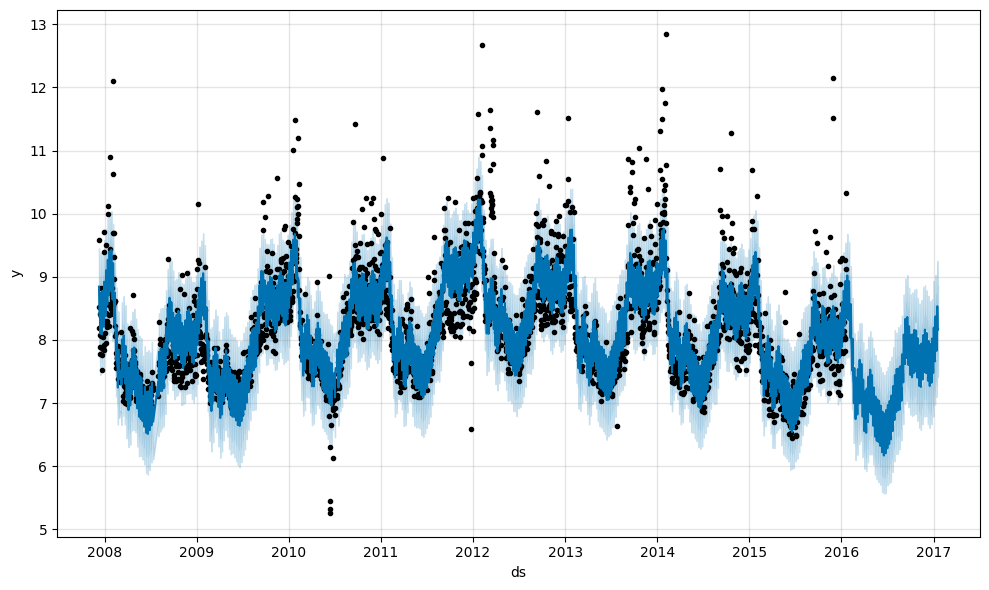

In [94]:
forecast_pic_1 = model.plot(forecast)

На графике можно отчетливо увидеть сезонные колебания и другие тренды, однако, если исторических точек слишком много, то такая визуализация будет не очень показательной. И вот пример из другого датасета как это может выглядеть:

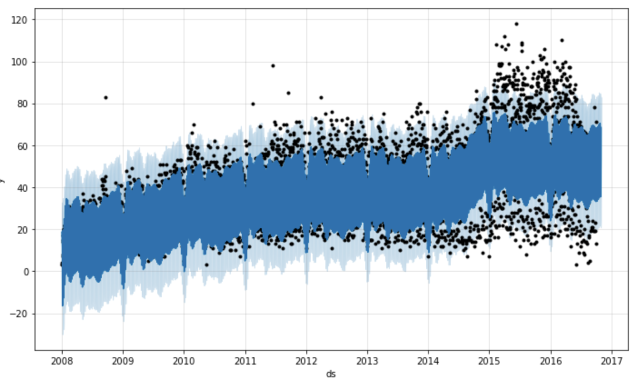

Согласитесь похоже на то, что художник разлил синию краску, и она стекла в одну линию, но даже так можно заметить легкий тренд к увеличению.

Поэтому в библиотеке Prophet был рзрботан еще один интересный метод - Prophet.plot_components, который позволяет посмотреть отдельно на компоненты: тренд, годовую и недельную сезонность. Если при построении модели были заданы аномальные дни/праздники, то они также будут отображаться на этом графике.

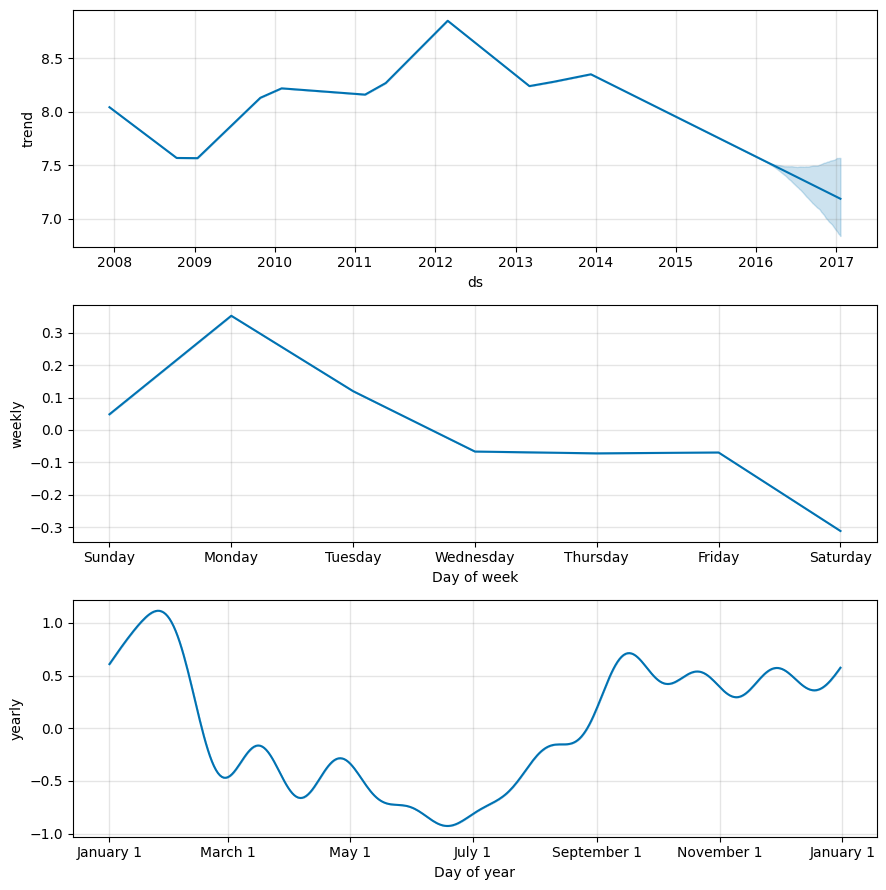

In [95]:
forecast_pic_second = model.plot_components(forecast)

Как видим, слева от каждого графика указано к какому компоненту он относится (weekly, yearly, trend etc), а также подписаны оси (Day of year, day of week etc) Что является приятным бонусом

Попробуем еще добавить аномальные дни, чтобы посмотреть на графики

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmptg2_vgdu/d7_qz7m5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptg2_vgdu/jzn6dy9_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99542', 'data', 'file=/tmp/tmptg2_vgdu/d7_qz7m5.json', 'init=/tmp/tmptg2_vgdu/jzn6dy9_.json', 'output', 'file=/tmp/tmptg2_vgdu/prophet_modelf6kt5zq7/prophet_model-20231125215343.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:53:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:53:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


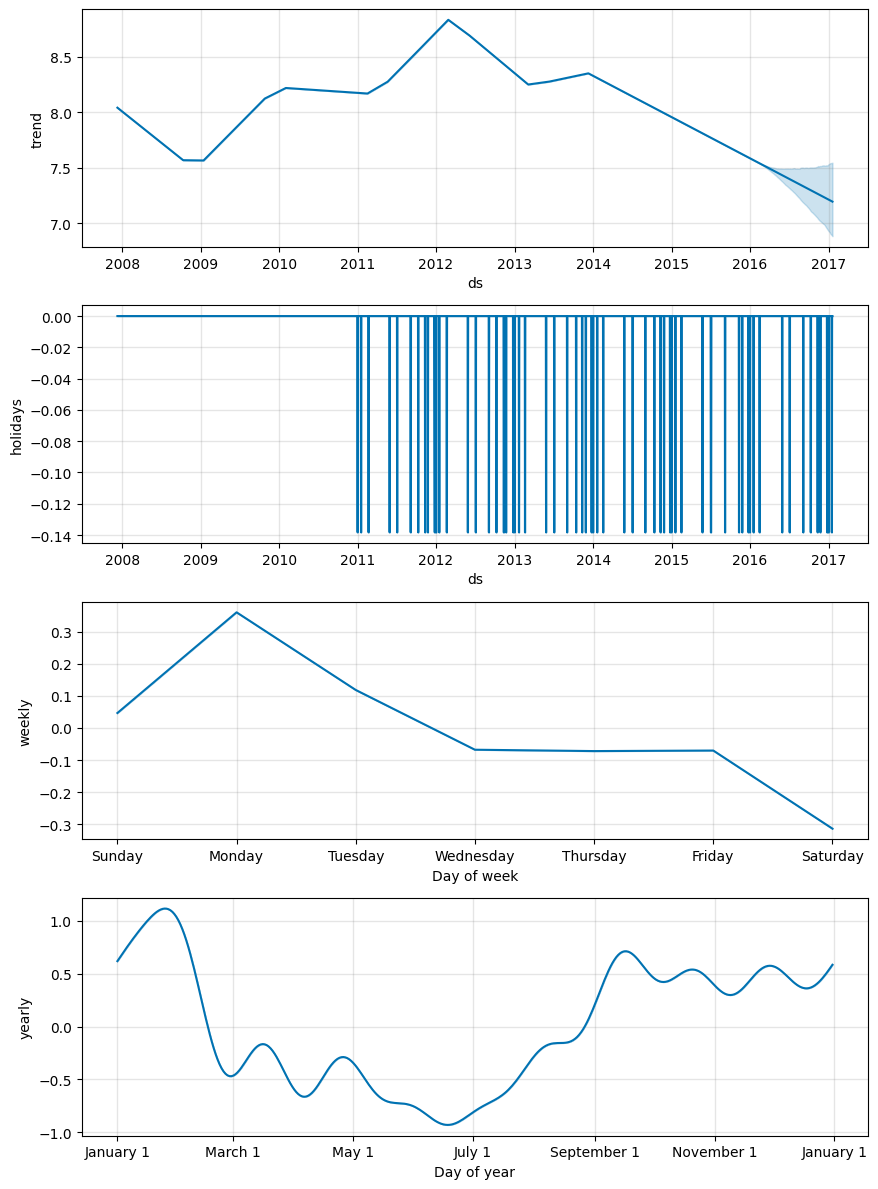

In [96]:
#Библиотека для каникул
import holidays

df_copy=df.copy(deep=True)

# Добавим даты каникул США

us_holidays = holidays.UnitedStates(years=range(2011, 2023))

#Делаем аккуратный дата фрейм

holidays = pd.DataFrame({
    'holiday': 'special_event',
    'ds': [date for date, name in sorted(us_holidays.items())]
})

#Создаем экземпляр класса Prophet

model_anom = Prophet(holidays=holidays)

#Тренируем

model_anom.fit(df_copy)

# Заглядываем в будущее :)

future_new = model_anom.make_future_dataframe(periods=365)

forecast_new = model_anom.predict(future_new)

#Рисовашки
forecast_pic_second_new = model_anom.plot_components(forecast_new)

Как можем видеть, появился еще один график holidays на котром заметны аномальные изменения в эти дни

Для создания интерактивного графика прогноза и его компонентов можно воспользоваться библиотекой Plotly. Обратите внимание, что необходимо установить версию Plotly 4.0 или выше, так как эта библиотека не включена в состав Prophet по умолчанию. Также убедитесь, что у вас установлены пакеты notebook и ipywidgets.

In [97]:
!pip install plotly>=4.0
!pip install notebook ipywidgets
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(model, forecast)



И опять-таки есть возможность разбить на отдельные компоненты

In [98]:
plot_components_plotly(model, forecast)

**Насыщающие прогнозы**

При прогнозировании роста обычно существует определенная максимальная точка достижения: общий размер рынка, общий размер населения и т. д. Это называется предельной вместимостью, и прогноз должен насыщаться на этой точке. Prophet позволяет делать прогнозы с использованием модели тренда логистического роста с указанной предельной вместимостью.

Выглядит это так:

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmptg2_vgdu/41bt32x4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptg2_vgdu/r6ie0v0n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35798', 'data', 'file=/tmp/tmptg2_vgdu/41bt32x4.json', 'init=/tmp/tmptg2_vgdu/r6ie0v0n.json', 'output', 'file=/tmp/tmptg2_vgdu/prophet_modelwn52an21/prophet_model-20231125215355.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:53:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:53:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


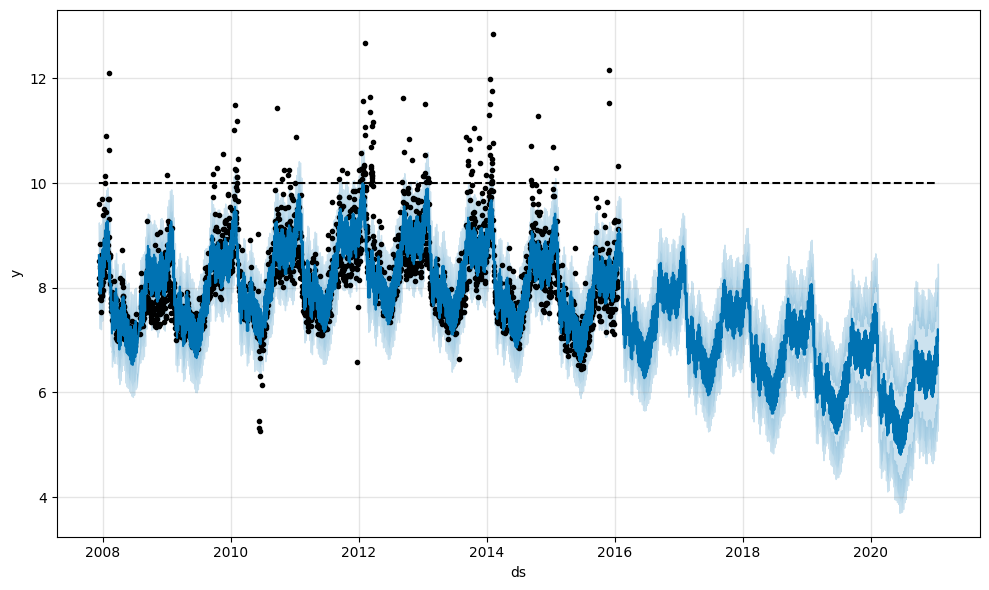

In [99]:
import pandas as pd
from pandas.plotting import register_matplotlib_converters


df_sat = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv')

# Добавляем capacity

df_sat['cap'] = 10

# Новый сет - новая моедль :)

model_sat = Prophet(growth='logistic')
model_sat.fit(df_sat)
register_matplotlib_converters()

# Переход к будущему
future_sat = model_sat.make_future_dataframe(periods=1826)
future_sat['cap'] = 10
fcst = model_sat.predict(future_sat)
fig_sat = model_sat.plot(fcst)
fig_sat.show()



Аналогично можно и делать min capacity

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmptg2_vgdu/v8fw7yl2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptg2_vgdu/m_2bkk0d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97949', 'data', 'file=/tmp/tmptg2_vgdu/v8fw7yl2.json', 'init=/tmp/tmptg2_vgdu/m_2bkk0d.json', 'output', 'file=/tmp/tmptg2_vgdu/prophet_modelz66w09ud/prophet_model-20231125215405.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:54:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:54:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


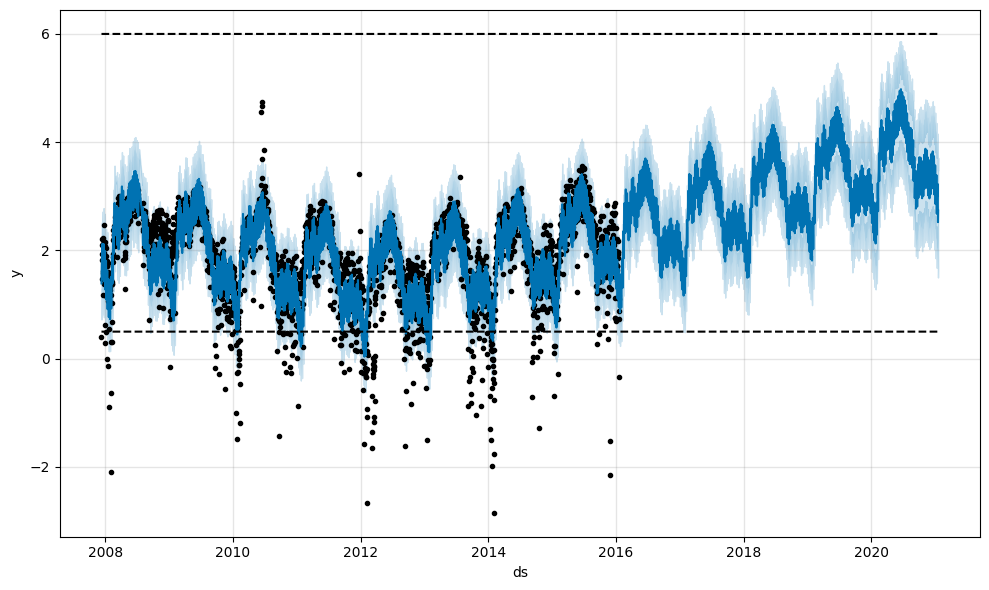

In [100]:
df_sat['y'] = 10 - df['y']
df_sat['cap'] = 6
df_sat['floor'] = 0.5
future_sat['cap'] = 6
future_sat['floor'] = 0.5
mod_sat = Prophet(growth='logistic')
mod_sat.fit(df_sat)
fcst = mod_sat.predict(future_sat)
fig = mod_sat.plot(fcst)
fig.show()

**Изменения в тренде**

Реальные временные ряды часто имеют резкие изменения в своих траекториях. По умолчанию Prophet автоматически обнаруживает эти точки изменения и позволяет тренду адаптироваться соответственно.

Однако, если вы хотите более тщательно управлять этим процессом (например, если Prophet упустил изменение темпа или переобучается на изменения темпа в истории), то есть несколько входных аргументов, которые можно использовать.

Параметр n_changepoints можно использовать для установки количества потенциальных точек изменения, но часто более эффективным является тонкая настройка этого параметра путем регулировки. Местоположение значимых точек изменения можно визуализировать с использованием соответствующих инструментов.

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmptg2_vgdu/r00h3hu9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptg2_vgdu/l6nmjnbv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54565', 'data', 'file=/tmp/tmptg2_vgdu/r00h3hu9.json', 'init=/tmp/tmptg2_vgdu/l6nmjnbv.json', 'output', 'file=/tmp/tmptg2_vgdu/prophet_modelszovojui/prophet_model-20231125215622.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:56:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:56:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


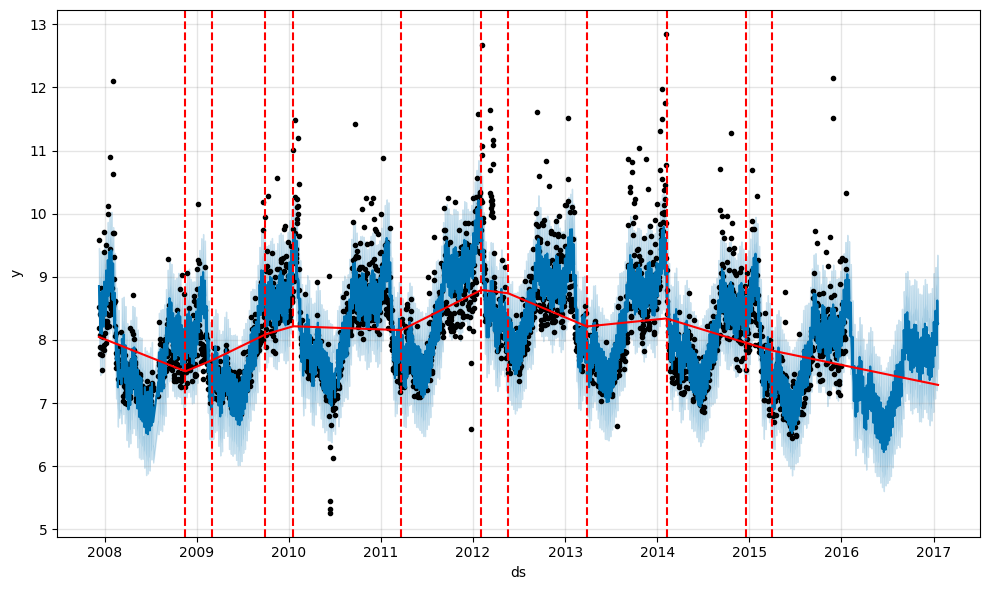

In [102]:
from prophet.plot import add_changepoints_to_plot
df_change_p = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv')

model_change_p = Prophet(changepoint_range=0.9)
model_change_p.fit(df_change_p)

future_change_p = model_change_p.make_future_dataframe(periods=365)
forecast_change_p = model_change_p.predict(future_change_p)

fig_change_p = model_change_p.plot(forecast_change_p)
modified_change_p = add_changepoints_to_plot(fig_change_p.gca(), model_change_p, forecast_change_p)


Довольно отчетливо видим точки изменения и с их помощью можем построить общую кривую изменения (кривую тренда - красная ломаная линия)

Настройка гибкости тренда

Если изменения в тренде переобучаются (слишком гибкий) или недообучаются (недостаточно гибкий), можно корректировать степень разреженности априорного распределения с помощью параметра changepoint_prior_scale. По умолчанию этот параметр установлен на 0,05. Увеличение его значения сделает тренд более гибким:

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmptg2_vgdu/lbb8oy4l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptg2_vgdu/rj1rzs4v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7906', 'data', 'file=/tmp/tmptg2_vgdu/lbb8oy4l.json', 'init=/tmp/tmptg2_vgdu/rj1rzs4v.json', 'output', 'file=/tmp/tmptg2_vgdu/prophet_modelg_spta6x/prophet_model-20231125215640.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:56:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:56:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


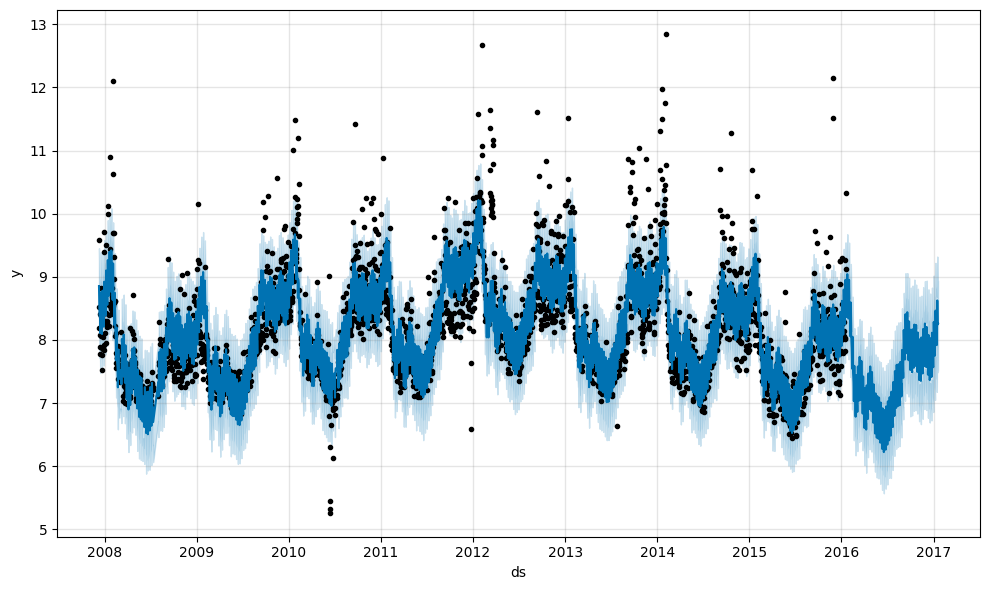

In [103]:
from prophet.plot import add_changepoints_to_plot
df_change_flex = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv')

model_change_flex = Prophet(changepoint_range=0.9)
model_change_flex.fit(df_change_flex)

future_change_flex = model_change_flex.make_future_dataframe(periods=365)
forecast_change_flex = model_change_flex.predict(future_change_flex)

fig_lex = model_change_flex.plot(forecast_change_flex)
modiffied_fflex = add_changepoints_to_plot(fig.gca(), model_change_flex, forecast_change_flex)

Как видим тренд действительно стал более гибким (светло-голубая часть графика)

**Мультипликативная сезонность**

В эконометрике помимо аддитивной сезонности, с которой мы уже работали выше, есть еще мультипликативная сезонность и это совсем разные модели. Для работы с мультипликативной сезонностью следует использовть параметр seasonality_mode='multiplicative' при вызове Prophet()

Пример:

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmptg2_vgdu/eyb1rr5h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptg2_vgdu/a1myp305.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11310', 'data', 'file=/tmp/tmptg2_vgdu/eyb1rr5h.json', 'init=/tmp/tmptg2_vgdu/a1myp305.json', 'output', 'file=/tmp/tmptg2_vgdu/prophet_modelzkpuxzz7/prophet_model-20231125221341.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonalit

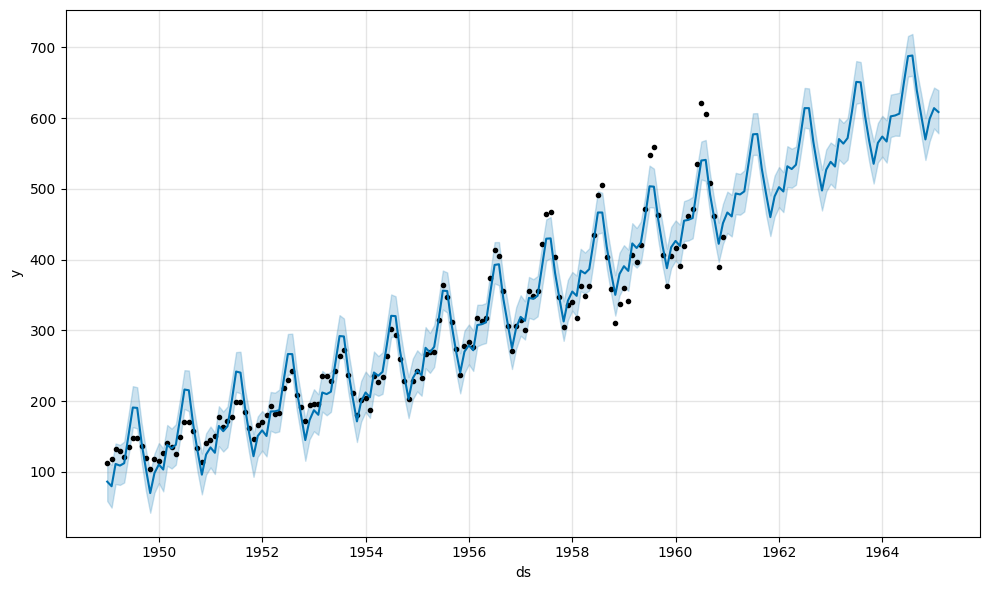

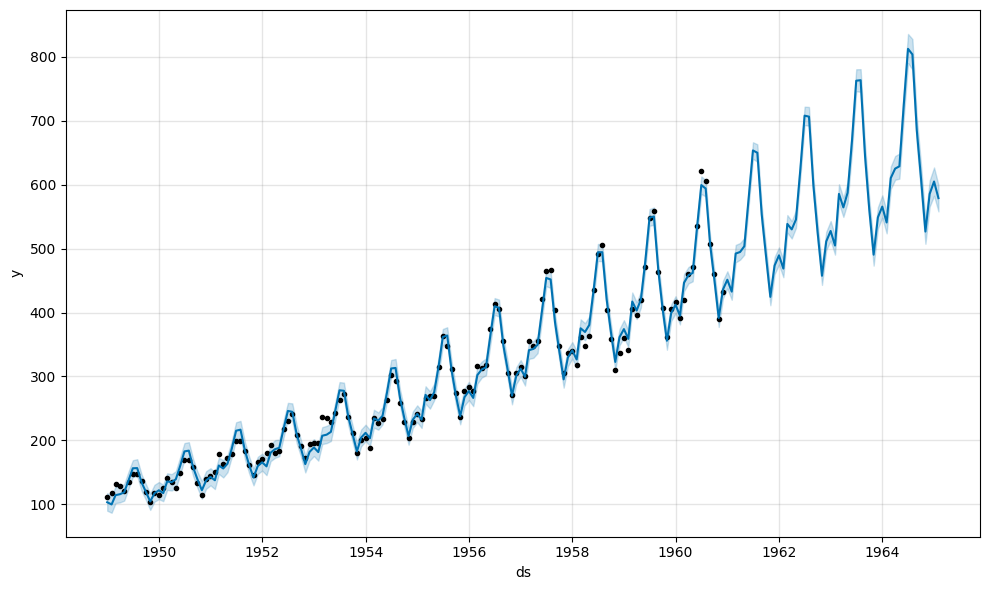

In [105]:
# Новы датасет посвящен количеству пассажиров самолета

# Рассмотрим сначала без мультипликативности сезонности
df_non_mult = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_air_passengers.csv')
model_non_mult = Prophet()
model_non_mult.fit(df_non_mult)
future_non_mult = model_non_mult.make_future_dataframe(50, freq='MS')
forecast_non_mult = model_non_mult.predict(future_non_mult)
fig_non_mult = model_non_mult.plot(forecast_non_mult)


# Теперь с мультипликативностью

df_mult = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_air_passengers.csv')
model_mult = Prophet(seasonality_mode='multiplicative')
model_mult.fit(df_mult)
future_mult = model_mult.make_future_dataframe(50, freq='MS')
forecast_mult = model_mult.predict(future_mult)
fig_mult = model_mult.plot(forecast_mult)



В первом временном ряду четко прослеживается ежегодный цикл, однако сезонность в прогнозе слишком выражена в начале временного ряда и слишком слаба в конце. В данном временном ряде сезонность не является постоянным аддитивным фактором, как это предполагает модель Prophet, а, наоборот, она растет вместе с трендом. Это мультипликативная сезонность.

Поэтому при построении второно графика мы указали seasonality_mode='multiplicative' и теперь, как видно, сезонность действительно является постоянным фактором, а значит наши прогнозы будут более точны.

**Оценка модели**

Ну вот мы и подошли к заключительной части конспекта - диагностика нашей модели.

Прогнозирование ошибок в Prophet осуществляется с использованием временной перекрестной проверки с целью измерения ошибки прогноза с использованием исторических данных. Это достигается выбором точек отсечения в истории, и для каждой из них модель подгоняется, используя данные только до этой точки отсечения. Затем прогнозные значения сравниваются с фактическими значениями.


Эта процедура перекрестной проверки может быть автоматизирована для различных исторических точек отсечения с использованием функции cross_validation. Мы указываем горизонт прогноза (horizon), а также по желанию размер начального периода обучения (initial) и интервал между точками отсечения (period). По умолчанию начальный период обучения устанавливается в три раза горизонт, и отсечки делаются каждые полгоризонта.

Результатом выполнения cross_validation является фрейм данных с фактическими значениями y и прогнозными значениями yhat для каждой симулированной даты прогноза и для каждой точки отсечения. В частности, прогноз делается для каждой наблюдаемой точки между отсечкой и отсечкой + горизонт. Этот фрейм данных затем может быть использован для вычисления показателей ошибок между yhat и y.

Опять-таки код с примером:

In [109]:
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

df_last = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_air_passengers.csv')
model_last = Prophet()
model_last.fit(df_last)
future_last = model_last.make_future_dataframe(50, freq='MS')
forecast_last = model_last.predict(future_last)

df_cv = cross_validation(model_last, initial='730 days', period='180 days', horizon = '365 days')
df_cv.head(10)

# Посмторим на разные парметры ошибок и качеств модели - MSE RMSE etc

df_p = performance_metrics(df_cv)
df_p.head(10)




INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmptg2_vgdu/ov2mjrw9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptg2_vgdu/1bc89m2e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50458', 'data', 'file=/tmp/tmptg2_vgdu/ov2mjrw9.json', 'init=/tmp/tmptg2_vgdu/1bc89m2e.json', 'output', 'file=/tmp/tmptg2_vgdu/prophet_modelbr70uyha/prophet_model-20231125224846.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:48:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:48:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 19 forecasts with cu

  0%|          | 0/19 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 19.
DEBUG:cmdstanpy:input tempfile: /tmp/tmptg2_vgdu/g7qjzejd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptg2_vgdu/zulhbasi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4221', 'data', 'file=/tmp/tmptg2_vgdu/g7qjzejd.json', 'init=/tmp/tmptg2_vgdu/zulhbasi.json', 'output', 'file=/tmp/tmptg2_vgdu/prophet_modelely2y18k/prophet_model-20231125224846.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
22:48:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:48:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmptg2_vgdu/qnahqotf.json
DEBUG:cmdstanpy:input tempfil

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,40 days,1089.760435,33.011520,25.888183,0.078584,0.073832,0.079624,0.227273
1,42 days,1015.074527,31.860234,25.207161,0.076726,0.073832,0.077409,0.181818
2,46 days,909.815509,30.163148,24.622042,0.078579,0.078888,0.078319,0.136364
3,47 days,1044.416363,32.317431,26.737368,0.081351,0.085408,0.081498,0.136364
4,48 days,1034.025454,32.156266,26.194461,0.079480,0.085408,0.079693,0.181818
5,51 days,1148.624226,33.891359,27.942551,0.084622,0.088177,0.084326,0.181818
6,52 days,1173.361603,34.254366,28.085277,0.084137,0.088177,0.083836,0.227273
7,53 days,1132.081487,33.646419,27.087316,0.081773,0.085408,0.081700,0.227273
8,56 days,1173.139506,34.251124,27.659617,0.083656,0.086788,0.082998,0.227273
9,57 days,1382.111880,37.176765,28.990610,0.083266,0.081656,0.083049,0.227273


Метрики производительности перекрестной проверки могут быть визуализированы с использованием функции plot_cross_validation_metric. Точки отображают абсолютную процентную ошибку для каждого прогноза в df_cv. Синяя линия показывает MAPE, где среднее значение берется по скользящему окну точек.

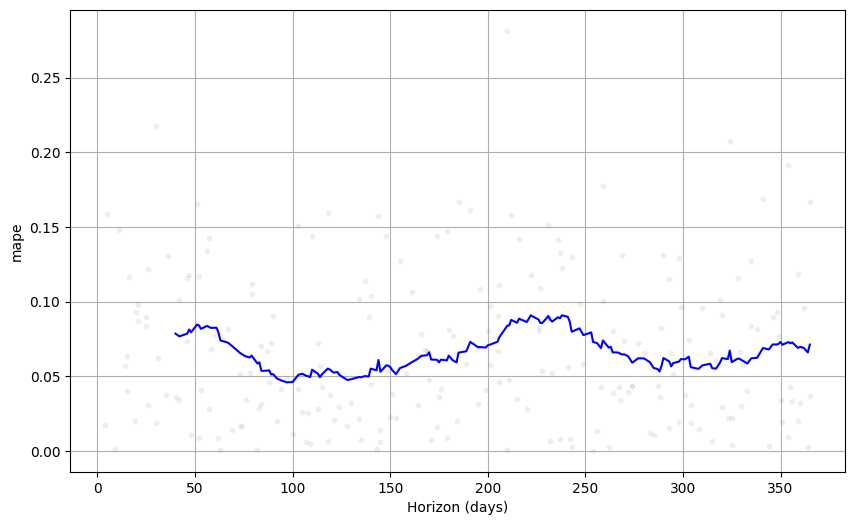

In [110]:
from prophet.plot import plot_cross_validation_metric
fig_last = plot_cross_validation_metric(df_cv, metric='mape')

**Заключение**

Prophet выделяется как мощный и удобный инструмент для прогнозирования временных рядов, который сочетает в себе простоту и гибкость, делая его ценным ресурсом для широкого спектра приложений в области прогнозирования. Prophet обладет большим количеством методов, которые помогают контролировать, визуализировать и анализировать различные данные. Prophet так же снабжен встроенным функционалом для проверки качества полученной модели.
